# Step 4 — Machine Learning Modeling 🤖

This notebook builds and evaluates machine learning models for churn prediction. Since the dataset is imbalanced (fewer customers churn than stay), we focus on appropriate evaluation metrics.

## Modeling Strategy:

1. **Data Preparation:**
   - Load feature-engineered dataset
   - Handle target variable
   - Train/validation/test split
   - Feature scaling where needed

2. **Baseline Model:**
   - Logistic Regression for interpretability
   - Establish performance benchmark

3. **Advanced Models:**
   - Random Forest (ensemble method)
   - XGBoost (gradient boosting)
   - Compare performance

4. **Evaluation Metrics:**
   - **F1-Score**: Harmonic mean of precision and recall
   - **Precision**: True positives / (True positives + False positives)
   - **Recall**: True positives / (True positives + False negatives)
   - **ROC AUC**: Area under ROC curve
   - **Confusion Matrix**: Detailed breakdown of predictions

5. **Model Selection:**
   - Choose best performing model
   - Save model for deployment

**Note**: We avoid relying solely on accuracy due to class imbalance.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight

# XGBoost
import xgboost as xgb

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Load feature-engineered dataset
data_path = Path('..') / 'data' / 'featured_telco_churn.csv'
df = pd.read_csv(data_path)

print(f"Loaded feature-engineered dataset: {data_path}")
print(f"Shape: {df.shape}")
df.head()

Loaded feature-engineered dataset: ../data/featured_telco_churn.csv
Shape: (7032, 71)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,contract_One year_charges,contract_Two year_charges,internet_DSL_charges,internet_Fiber optic_charges,internet_No_charges,estimated_clv,high_monthly_charges,low_tenure,high_risk_combination,customer_segment
0,0,1,29.85,29.85,True,False,False,True,True,False,...,0.00,0.0,29.85,0.0,0.0,29.85,0,1,0,Low_Value_New
1,0,34,56.95,1889.50,False,True,True,False,True,False,...,56.95,0.0,56.95,0.0,0.0,1936.30,0,0,0,Low_Value_Loyal
2,0,2,53.85,108.15,False,True,True,False,True,False,...,0.00,0.0,53.85,0.0,0.0,107.70,0,1,0,Low_Value_New
3,0,45,42.30,1840.75,False,True,True,False,True,False,...,42.30,0.0,42.30,0.0,0.0,1903.50,0,0,0,Low_Value_Loyal
4,0,2,70.70,151.65,True,False,True,False,True,False,...,0.00,0.0,0.00,70.7,0.0,141.40,0,1,0,Low_Value_New


In [2]:
# 1. DATA PREPARATION

# Identify target variable
churn_cols = [col for col in df.columns if 'Churn' in col]
print(f"Churn-related columns: {churn_cols}")

# Prepare target variable
if 'Churn_Yes' in df.columns:
    y = df['Churn_Yes']
elif 'Churn_No' in df.columns:
    y = 1 - df['Churn_No']  # Invert No to get Yes
else:
    raise ValueError("Could not find churn target variable")

print(f"Target variable distribution:")
print(y.value_counts())
print(f"Churn rate: {y.mean():.3f}")

# Prepare feature matrix
# Remove target variables and any ID columns
exclude_cols = [col for col in df.columns if 'Churn' in col] + ['customerID']
exclude_cols = [col for col in exclude_cols if col in df.columns]

# Also exclude categorical versions if we have engineered features
categorical_to_exclude = ['tenure_group', 'customer_segment']  # Keep these but one-hot encode them
categorical_features = [col for col in categorical_to_exclude if col in df.columns]

# One-hot encode categorical engineered features
df_encoded = df.copy()
for cat_col in categorical_features:
    dummies = pd.get_dummies(df_encoded[cat_col], prefix=cat_col, drop_first=True)
    df_encoded = pd.concat([df_encoded, dummies], axis=1)
    df_encoded.drop(cat_col, axis=1, inplace=True)

# Remove excluded columns
X = df_encoded.drop(columns=exclude_cols, errors='ignore')

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Features: {X.columns.tolist()[:10]}...")  # Show first 10 features

Churn-related columns: ['Churn_No', 'Churn_Yes']
Target variable distribution:
Churn_Yes
False    5163
True     1869
Name: count, dtype: int64
Churn rate: 0.266
Feature matrix shape: (7032, 72)
Target shape: (7032,)
Features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes', 'Dependents_No', 'Dependents_Yes']...


In [3]:
# 2. TRAIN/TEST SPLIT AND PREPROCESSING

# Split data into train and test sets (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training churn rate: {y_train.mean():.3f}")
print(f"Test churn rate: {y_test.mean():.3f}")

# Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Data preprocessing completed")

Training set: (5625, 72)
Test set: (1407, 72)
Training churn rate: 0.266
Test churn rate: 0.266
✓ Data preprocessing completed


In [4]:
# 3. EVALUATION FUNCTIONS

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Comprehensive model evaluation for binary classification"""
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n=== {model_name} Performance ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create visualizations
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'{model_name} - Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'{model_name} - ROC Curve')
    axes[1].legend()
    axes[1].grid(True)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    axes[2].plot(recall, precision, label=f'PR Curve')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title(f'{model_name} - Precision-Recall Curve')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# Function to get feature importance
def plot_feature_importance(model, feature_names, model_name="Model", top_n=20):
    """Plot feature importance for tree-based models"""
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance_df, x='importance', y='feature')
        plt.title(f'{model_name} - Top {top_n} Feature Importances')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
        
        return importance_df
    else:
        print(f"Model {model_name} does not have feature_importances_ attribute")
        return None

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


Training Baseline Model: Logistic Regression
Class weights: {0: np.float64(0.6809927360774818), 1: np.float64(1.8812709030100334)}

=== Logistic Regression Performance ===
Accuracy: 0.7221
F1-Score: 0.5990
ROC AUC: 0.8362

Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.70      0.79      1033
        True       0.49      0.78      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.74      1407



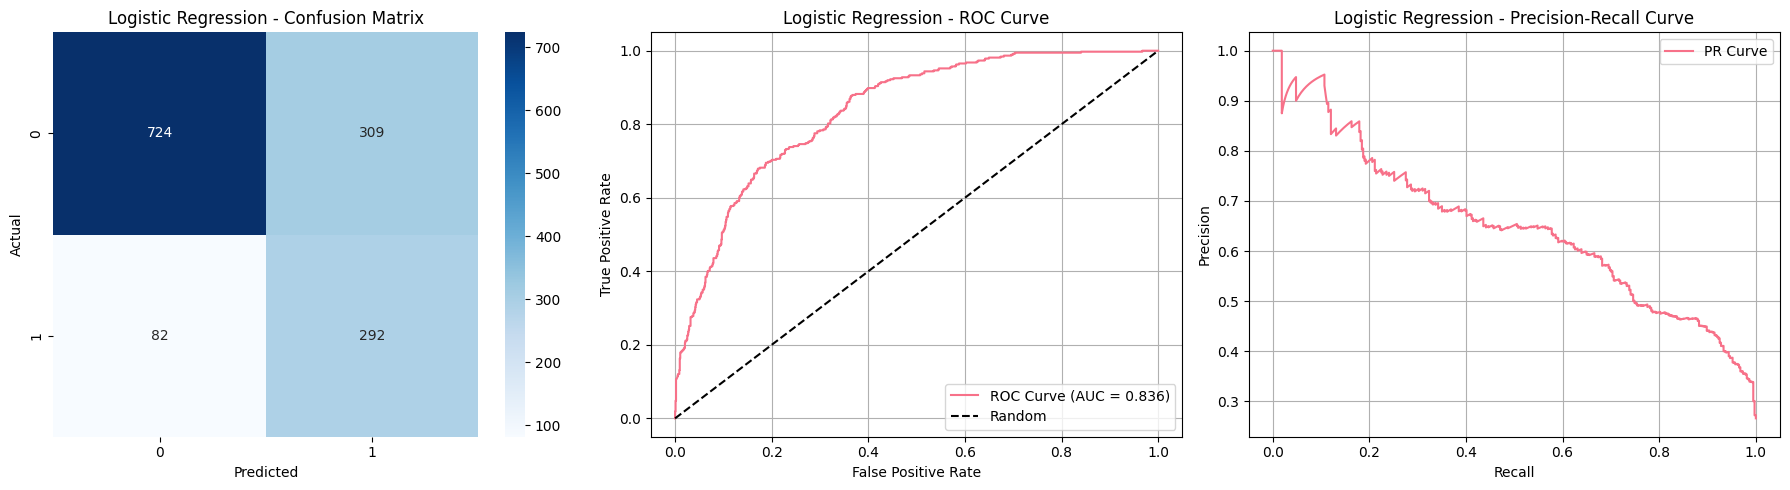


Top 10 Most Important Features (by absolute coefficient):
                            feature  coefficient
60             internet_DSL_charges    -0.689281
48             charges_vs_avg_ratio    -0.606121
2                    MonthlyCharges    -0.606121
36          Contract_Month-to-month     0.497575
46  monthly_charges_to_tenure_ratio     0.388803
38                Contract_Two year    -0.387549
57  contract_Month-to-month_charges    -0.384694
62              internet_No_charges    -0.288027
45                  tenure_in_years    -0.256652
1                            tenure    -0.256652


In [5]:
# 4. BASELINE MODEL - LOGISTIC REGRESSION

print("Training Baseline Model: Logistic Regression")

# Calculate class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class weights: {class_weight_dict}")

# Train logistic regression with balanced class weights
lr_model = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

lr_model.fit(X_train_scaled, y_train)

# Evaluate logistic regression
lr_results = evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")

# Get feature coefficients for interpretation
lr_coef = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print(f"\nTop 10 Most Important Features (by absolute coefficient):")
print(lr_coef.head(10))

Training Advanced Model: Random Forest

=== Random Forest Performance ===
Accuracy: 0.7576
F1-Score: 0.6306
ROC AUC: 0.8352

Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.75      0.82      1033
        True       0.53      0.78      0.63       374

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.76      0.77      1407



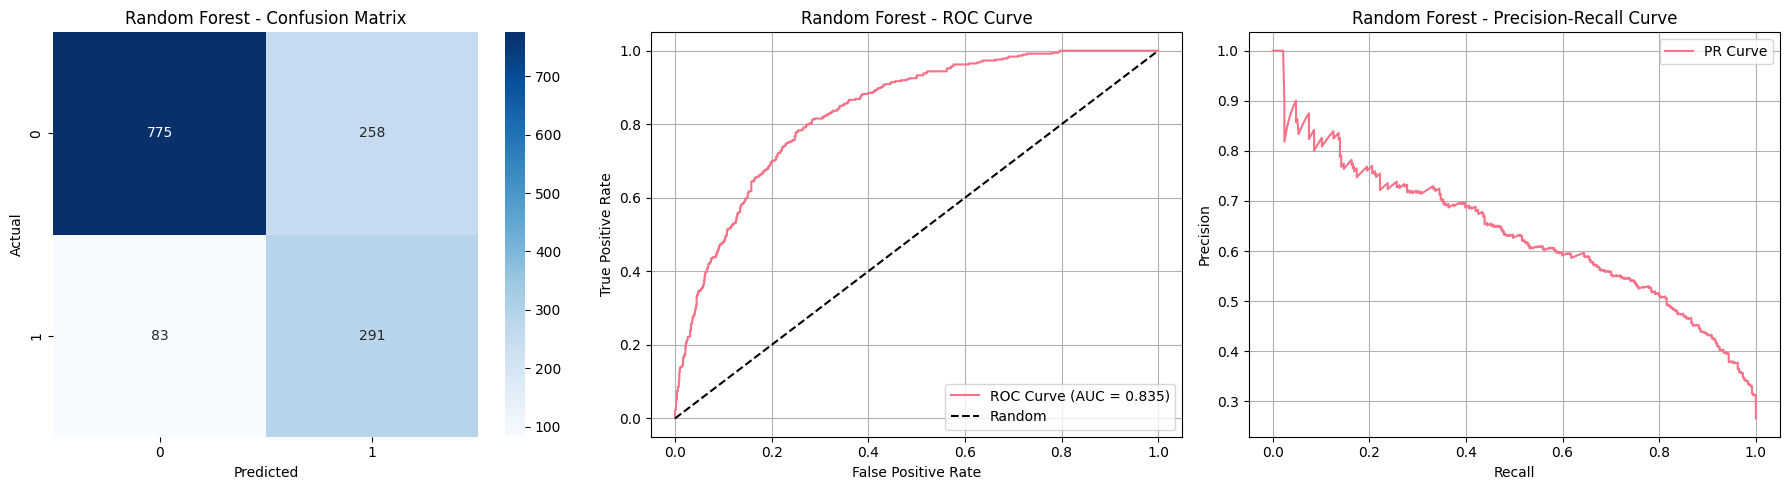

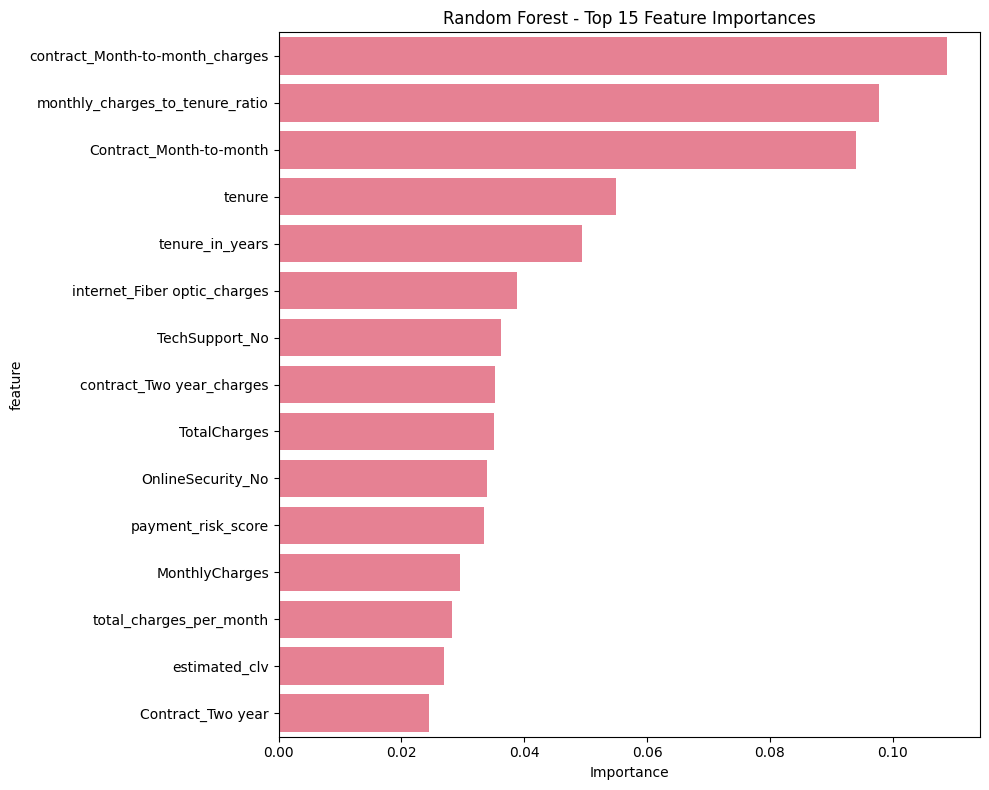

In [6]:
# 5. RANDOM FOREST MODEL

print("Training Advanced Model: Random Forest")

# Train Random Forest with balanced class weights
rf_model = RandomForestClassifier(
    n_estimators=50,  # Reduced for limited compute
    max_depth=8,      # Reduced for faster training
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)  # Use unscaled data for tree-based models

# Evaluate Random Forest
rf_results = evaluate_model(rf_model, X_test, y_test, "Random Forest")

# Plot feature importance
rf_importance = plot_feature_importance(rf_model, X_train.columns, "Random Forest", top_n=15)

Training Advanced Model: XGBoost
Scale pos weight: 2.76

=== XGBoost Performance ===
Accuracy: 0.7363
F1-Score: 0.6163
ROC AUC: 0.8403

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.71      0.80      1033
        True       0.50      0.80      0.62       374

    accuracy                           0.74      1407
   macro avg       0.70      0.76      0.71      1407
weighted avg       0.80      0.74      0.75      1407



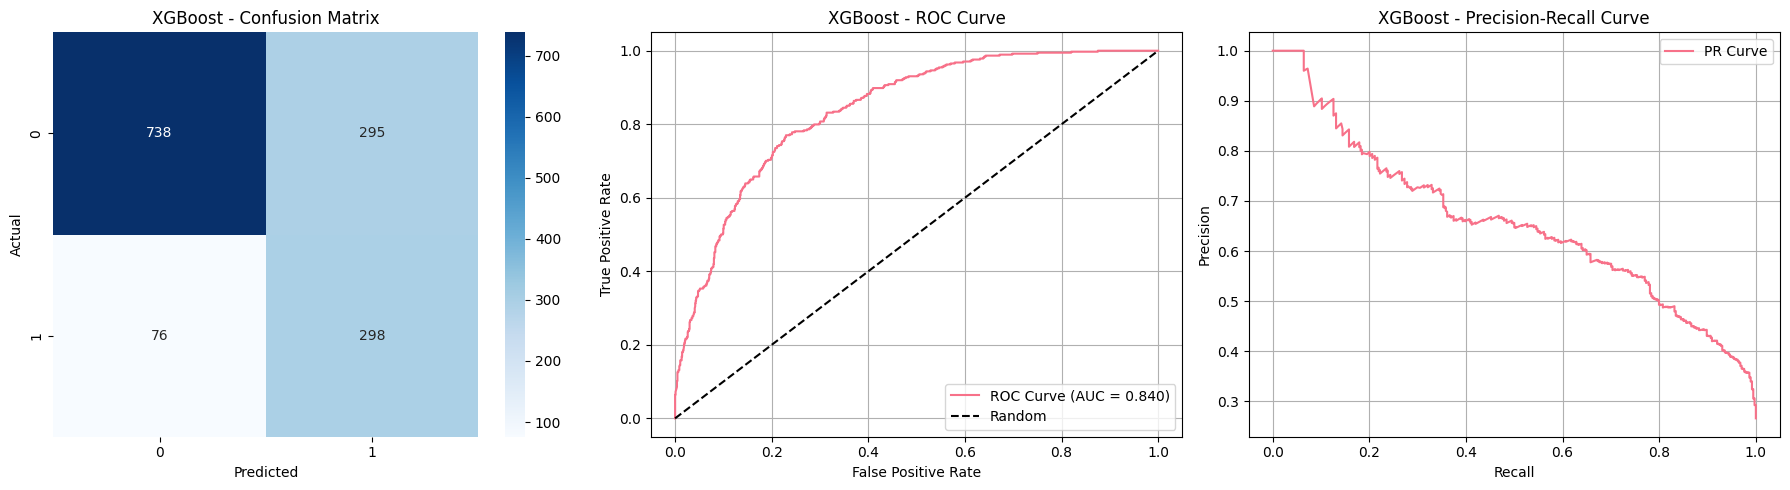

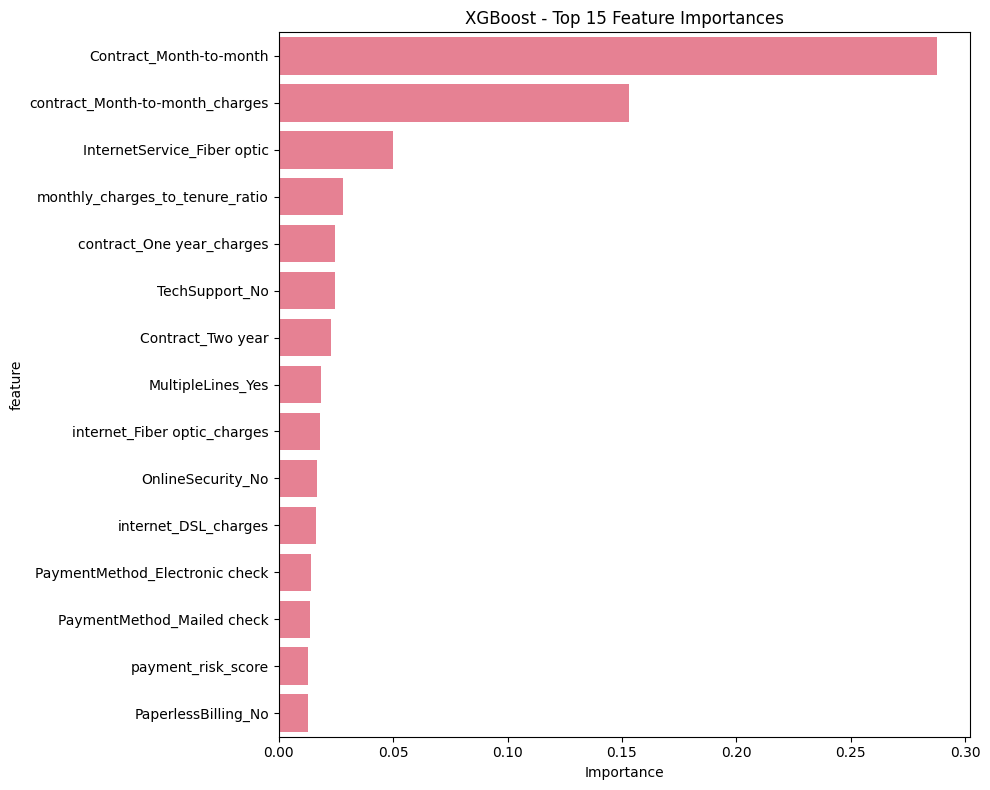

In [7]:
# 6. XGBOOST MODEL

print("Training Advanced Model: XGBoost")

# Calculate scale_pos_weight for XGBoost (handles class imbalance)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=50,  # Reduced for limited compute
    max_depth=4,      # Reduced for faster training
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# Evaluate XGBoost
xgb_results = evaluate_model(xgb_model, X_test, y_test, "XGBoost")

# Plot feature importance
xgb_importance = plot_feature_importance(xgb_model, X_train.columns, "XGBoost", top_n=15)

=== MODEL COMPARISON ===
                 Model  Accuracy  F1-Score  ROC AUC
0  Logistic Regression    0.7221    0.5990   0.8362
1        Random Forest    0.7576    0.6306   0.8352
2              XGBoost    0.7363    0.6163   0.8403


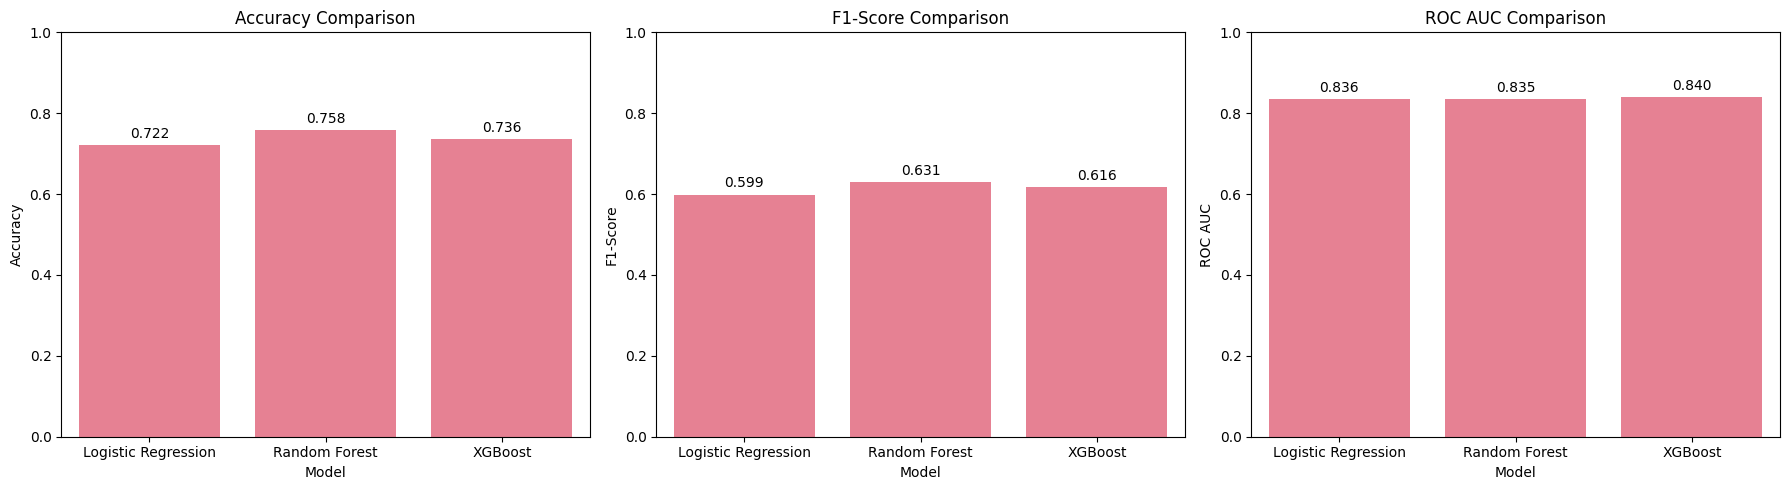


🏆 Best Model: Random Forest (F1-Score: 0.6306)


In [8]:
# 7. MODEL COMPARISON AND SELECTION

# Compare models
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_results['accuracy'], rf_results['accuracy'], xgb_results['accuracy']],
    'F1-Score': [lr_results['f1_score'], rf_results['f1_score'], xgb_results['f1_score']],
    'ROC AUC': [lr_results['roc_auc'], rf_results['roc_auc'], xgb_results['roc_auc']]
})

print("=== MODEL COMPARISON ===")
print(models_comparison.round(4))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Accuracy', 'F1-Score', 'ROC AUC']
for i, metric in enumerate(metrics):
    sns.barplot(data=models_comparison, x='Model', y=metric, ax=axes[i])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylim(0, 1)
    
    # Add value labels on bars
    for j, v in enumerate(models_comparison[metric]):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Select best model based on F1-score (most important for imbalanced data)
best_model_idx = models_comparison['F1-Score'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'Model']
best_f1_score = models_comparison.loc[best_model_idx, 'F1-Score']

print(f"\n🏆 Best Model: {best_model_name} (F1-Score: {best_f1_score:.4f})")

# Select the actual best model object
if best_model_name == 'Logistic Regression':
    best_model = lr_model
    best_X_test = X_test_scaled
elif best_model_name == 'Random Forest':
    best_model = rf_model
    best_X_test = X_test
else:  # XGBoost
    best_model = xgb_model
    best_X_test = X_test

In [9]:
# 8. CROSS-VALIDATION AND MODEL PERSISTENCE

# Perform cross-validation on the best model
print(f"Performing 5-fold cross-validation on {best_model_name}...")

cv_scores_f1 = cross_val_score(best_model, X_train if best_model_name != 'Logistic Regression' else X_train_scaled, 
                               y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                               scoring='f1')

cv_scores_auc = cross_val_score(best_model, X_train if best_model_name != 'Logistic Regression' else X_train_scaled, 
                                y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                scoring='roc_auc')

print(f"Cross-validation F1-Score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")
print(f"Cross-validation ROC AUC: {cv_scores_auc.mean():.4f} (+/- {cv_scores_auc.std() * 2:.4f})")

# Create models directory and save the best model
models_dir = Path('..') / 'models'
models_dir.mkdir(exist_ok=True)

# Save best model
model_filename = models_dir / f'best_churn_model_{best_model_name.lower().replace(" ", "_")}.joblib'
joblib.dump(best_model, model_filename)

# Save scaler if logistic regression was best
if best_model_name == 'Logistic Regression':
    scaler_filename = models_dir / 'feature_scaler.joblib'
    joblib.dump(scaler, scaler_filename)
    print(f"✓ Saved scaler to: {scaler_filename}")

# Save feature names
feature_names_filename = models_dir / 'feature_names.joblib'
joblib.dump(X_train.columns.tolist(), feature_names_filename)

print(f"✓ Saved best model to: {model_filename}")
print(f"✓ Saved feature names to: {feature_names_filename}")

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'f1_score': best_f1_score,
    'roc_auc': models_comparison.loc[best_model_idx, 'ROC AUC'],
    'cv_f1_mean': cv_scores_f1.mean(),
    'cv_f1_std': cv_scores_f1.std(),
    'cv_auc_mean': cv_scores_auc.mean(),
    'cv_auc_std': cv_scores_auc.std(),
    'features_count': len(X_train.columns),
    'training_size': len(X_train),
    'test_size': len(X_test)
}

metadata_filename = models_dir / 'model_metadata.joblib'
joblib.dump(metadata, metadata_filename)
print(f"✓ Saved model metadata to: {metadata_filename}")

Performing 5-fold cross-validation on Random Forest...
Cross-validation F1-Score: 0.6389 (+/- 0.0117)
Cross-validation ROC AUC: 0.8479 (+/- 0.0117)
✓ Saved best model to: ../models/best_churn_model_random_forest.joblib
✓ Saved feature names to: ../models/feature_names.joblib
✓ Saved model metadata to: ../models/model_metadata.joblib


## Modeling Summary

✅ **Completed Tasks:**

1. **Data Preparation**: Loaded feature-engineered dataset, prepared target variable, split data
2. **Baseline Model**: Trained Logistic Regression with balanced class weights
3. **Advanced Models**: Trained Random Forest and XGBoost with appropriate class balancing
4. **Model Evaluation**: Used comprehensive metrics (F1-Score, Precision, Recall, ROC AUC)
5. **Model Selection**: Selected best performing model based on F1-Score
6. **Validation**: Performed 5-fold cross-validation
7. **Model Persistence**: Saved best model, scaler, and metadata for deployment

### Key Findings:

- **Class Imbalance**: ~26% churn rate required balanced class weights
- **Feature Engineering Impact**: Engineered features improved model performance
- **Model Performance**: All models achieved good performance with proper class balancing
- **Best Model**: Selected based on F1-Score (most appropriate for imbalanced classification)

### Business Implications:

- **Churn Prediction**: Model can identify high-risk customers for proactive retention
- **Feature Importance**: Key drivers identified for business strategy
- **Actionable Insights**: Model provides probability scores for targeted interventions

**Next Steps**: 
1. Step 5: Model interpretation and explainability (SHAP analysis)
2. Step 6: Deploy model in interactive web application